In [1]:
# Enable autoreload to automatically reload modules when they are updated
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Dict, Any, Optional, Union
import joblib
import psutil
import os
import numpy as np
from sarpyx.processor.core.focus import CoarseRDA
from sarpyx.utils.zarr_utils import ZarrManager

# Only add path if not already added
cwd = Path.cwd()
sarpyx_path = cwd.parent
if str(sarpyx_path) not in __import__('sys').path:
    __import__('sys').path.append(str(sarpyx_path))
    
# Create output directory for stepped processing results
output_dir = cwd.parent / 'focused_data' 
output_dir.mkdir(parents=True, exist_ok=True)
print(f'📁 Output directory: {output_dir}')

📁 Output directory: /Data_large/marine/PythonProjects/SAR/sarpyx/focused_data


In [3]:
file_path = "/Data_large/marine/PythonProjects/SAR/sarpyx/decoded_data/s1a-s1-raw-s-hh-20150519t121652-20150519t121725-005990-007b7d_burst_0.zarr"
manager = ZarrManager(file_path)
raw_data = manager._export_raw()

In [4]:
def slice_section(data, k: int, N: int):
    """Slice data into the k-th section out of N sections."""
    total_length = len(data)
    section_size = total_length // N
    start_idx = k * section_size
    end_idx = (k + 1) * section_size if k < N - 1 else total_length
    return slice(start_idx, end_idx)

# Define the section parameters
k = 1  # Section index (0-based)
N = 4  # Total number of sections

# Apply slicing to raw_data
raw_data['echo'] = raw_data['echo'][slice_section(raw_data['echo'], k, N), :]
raw_data['metadata'] = raw_data['metadata'].iloc[slice_section(raw_data['metadata'], k, N)]

In [5]:
raw_data['echo'].shape

(15000, 25672)

In [6]:
processor = CoarseRDA(
            raw_data=raw_data,
            verbose=True,
        )

Memory efficient mode: enabled
Loaded radar data with shape: (15000, 25672)
Azimuth lines: 15000, Range lines: 25672
Data type: complex64
Memory usage: 2.87 GB
Generating transmission replica...
Range decimation code: 1
Range sample frequency: 100092592.64 Hz
TX pulse start frequency: -43801345.00 Hz
TX ramp rate: 1927378686407.00 Hz/s
TX pulse length: 0.000045 s
Number of TX values: 4549
Phase parameters - phi1: -460.87, phi2: 9.64e+11
Replica length: 4549
Transmission replica generated successfully!
Elapsed time for _generate_tx_replica: 0.1631 seconds


In [7]:
processor.data_focus()

Starting memory-efficient SAR data focusing...
Initial radar data shape: (15000, 25672)
RAM memory usage: 27.7%
Processing with original_w=25672
FFT input data shape: (15000, 25672)
RAM memory usage: 27.7%
Original radar data shape: (15000, 25672)
Performing FFT along range dimension (axis=1)...


First FFT along range dimension completed, shape: (15000, 25672)
RAM memory usage: 32.7%
Performing FFT along azimuth dimension (axis=0) with fftshift...
Second FFT along azimuth dimension completed, shape: (15000, 25672)
RAM memory usage: 32.7%
FFT output data shape: (15000, 25672)
- FFT performed successfully!
RAM memory usage: 32.7%
Elapsed time for fft2d: 30.2884 seconds
Memory usage: 27.7% -> 32.7% (Δ+5.0%)
Starting memory-efficient range compression...
Radar data shape: (15000, 25672)
RAM memory usage: 32.7%
Creating range filter for radar data shape: (15000, 25672)
Range dimension: 25672
TX replica length: 4549
Placing replica at indices [10561:15110] in filter of length 25672
Range filter shape: (25672,)
Elapsed time for get_range_filter: 0.2236 seconds
Memory usage: 32.7% -> 32.7% (Δ+0.0%)
Range filter shape: (25672,)
Applying range compression filter...
Debug: Attempting to multiply arrays with shapes (15000, 25672) and (25672,)
Debug: Broadcasting 1D array along range dimens

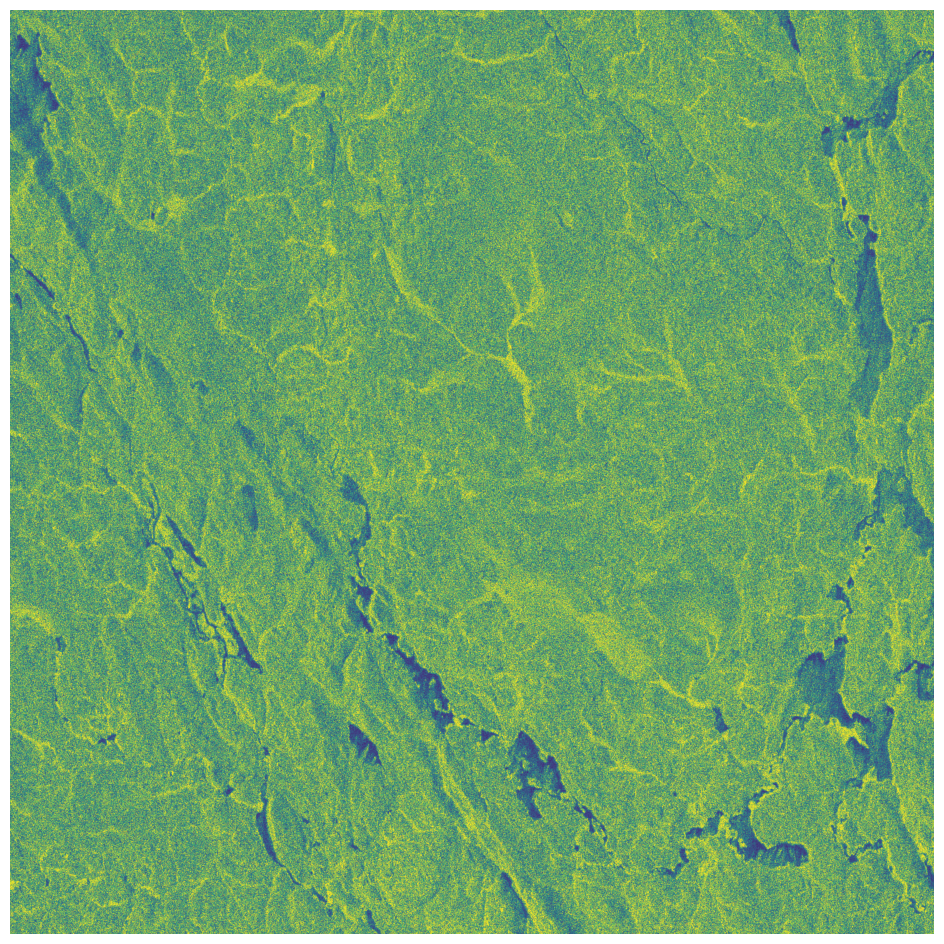

In [11]:
processor._display_slice(slice=(4000,7000,4000,7000), vmax=1100)

In [9]:
# Initialize the SteppedRDA focuser with chunking configuration
focuser = SteppedRDA(
    raw_data=raw_data,
    verbose=True,
    backend='numpy',
    save_intermediate=True,
    save_dir=output_dir,
    base_filename='sar_stepped_processing',
    compression_level=9,
    use_zarr=True
)

print('\n✅ SteppedRDA focuser initialized successfully!')
print(f'  Radar data shape: {focuser.radar_data.shape}')
print(f'  Backend: {focuser._backend}')
print(f'  Save directory: {focuser.save_dir}')
print(f'  Using Zarr: {focuser.use_zarr}')
print(f'  Compression level: {focuser.compression_level}')

NameError: name 'SteppedRDA' is not defined

# SAR Stepped Focusing API

This section provides an API to focus the SAR product using the SteppedRDA processor with intermediate step saving.
The API includes functions for:
- Stepped SAR focusing with intermediate product saving
- Loading and analyzing intermediate products
- Memory management and compression statistics

In [ ]:
def focus_sar_product_stepped(
    focuser: SteppedRDA, 
    save_all_steps: bool = True
) -> np.ndarray:
    """Focus SAR product using Stepped Range Doppler Algorithm with intermediate saving.
    
    Args:
        focuser (SteppedRDA): Initialized SteppedRDA processor instance.
        save_all_steps (bool): Whether to save all intermediate steps including raw and FFT.
        
    Returns:
        np.ndarray: Focused radar data array.
        
    Raises:
        AssertionError: If focuser is not properly initialized.
        Exception: If focusing process fails.
    """
    assert isinstance(focuser, SteppedRDA), 'focuser must be a SteppedRDA instance'
    assert hasattr(focuser, 'radar_data'), 'Focuser must be initialized with radar data'
    assert focuser.radar_data is not None, 'Radar data cannot be None'
    
    print('🚀 Starting stepped SAR product focusing...')
    print(f'Input data shape: {focuser.radar_data.shape}')
    print(f'Backend: {focuser._backend}')
    print(f'Save intermediate: {focuser.save_intermediate}')
    print(f'Save all steps: {save_all_steps}')
    
    try:
        # Run the stepped focusing algorithm
        focuser.main(save_all_steps=save_all_steps)
        
        print('✅ Stepped SAR focusing completed successfully!')
        print('📁 Intermediate products saved:')
        
        # List all saved files
        saved_files = focuser.list_saved_files()
        for file_path in saved_files:
            file_size = file_path.stat().st_size / (1024**2)  # Size in MB
            print(f'  - {file_path.name} ({file_size:.2f} MB)')
        
        return focuser.radar_data
        
    except Exception as e:
        print(f'❌ Error during stepped focusing: {str(e)}')
        print(f'📊 Debug info:')
        print(f'  Radar data shape: {focuser.radar_data.shape}')
        if hasattr(focuser, 'effective_velocities'):
            print(f'  Effective velocities shape: {focuser.effective_velocities.shape}')
        if hasattr(focuser, 'az_freq_vals'):
            print(f'  Azimuth freq vals shape: {focuser.az_freq_vals.shape}')
        if hasattr(focuser, 'D'):
            print(f'  D array shape: {focuser.D.shape}')
        if hasattr(focuser, 'slant_range_vec'):
            print(f'  Slant range vec shape: {focuser.slant_range_vec.shape}')
        raise


def load_intermediate_product(
    focuser: SteppedRDA, 
    step_name: str
) -> np.ndarray:
    """Load a specific intermediate processing step.
    
    Args:
        focuser (SteppedRDA): SteppedRDA processor instance.
        step_name (str): Name of the step to load ('raw_input', 'range_compression', 'rcmc', 'azimuth_compression').
        
    Returns:
        np.ndarray: Loaded radar data array for the specified step.
        
    Raises:
        FileNotFoundError: If the specified step file doesn't exist.
        ValueError: If unable to load the file.
    """
    try:
        data = focuser.load_step(step_name)
        print(f'✅ Loaded {step_name} successfully')
        print(f'  Shape: {data.shape}')
        print(f'  Data type: {data.dtype}')
        print(f'  Size: {data.nbytes / (1024**2):.2f} MB')
        return data
    except Exception as e:
        print(f'❌ Error loading {step_name}: {str(e)}')
        raise


def get_stepped_focusing_metadata(focuser: SteppedRDA) -> Dict[str, Any]:
    """Extract metadata information from the SteppedRDA processor.
    
    Args:
        focuser (SteppedRDA): Initialized SteppedRDA processor instance.
        
    Returns:
        Dict[str, Any]: Dictionary containing processing metadata.
    """
    metadata = {
        'backend': focuser._backend,
        'verbose': focuser._verbose,
        'data_shape': focuser.radar_data.shape,
        'save_intermediate': focuser.save_intermediate,
        'save_dir': str(focuser.save_dir) if focuser.save_dir else None,
        'use_zarr': focuser.use_zarr,
        'compression_level': focuser.compression_level,
        'base_filename': focuser.base_filename,
        'range_sample_freq': getattr(focuser, 'range_sample_freq', None),
        'replica_length': getattr(focuser, 'replica_len', None),
        'azimuth_lines': focuser.len_az_line,
        'range_lines': focuser.len_range_line,
    }
    
    # Add optional attributes if they exist
    optional_attrs = ['wavelength', 'pri', 'c', 'az_sample_freq']
    for attr in optional_attrs:
        if hasattr(focuser, attr):
            metadata[attr] = getattr(focuser, attr)
    
    return metadata



# print('📊 Processor metadata before focusing:')
# pre_focus_metadata = get_stepped_focusing_metadata(focuser)
# for key, value in pre_focus_metadata.items():
#     print(f'  {key}: {value}')

# Run the stepped focusing process
focused_radar_data = focus_sar_product_stepped(focuser, save_all_steps=False)

In [ ]:
def display_stepped_focusing_results(
    radar_data: np.ndarray, 
    focuser: SteppedRDA,
    metadata: Optional[Dict[str, Any]] = None
) -> None:
    """Display comprehensive information about the stepped focused radar data.
    
    Args:
        radar_data (np.ndarray): Focused radar data array.
        focuser (SteppedRDA): SteppedRDA processor instance.
        metadata (Optional[Dict[str, Any]]): Optional metadata dictionary.
    """
    print('=' * 60)
    print('📈 STEPPED SAR FOCUSING RESULTS')
    print('=' * 60)
    
    # Basic data information
    print('📊 Data Information:')
    print(f'  Shape: {radar_data.shape}')
    print(f'  Data type: {radar_data.dtype}')
    print(f'  Size: {radar_data.nbytes / (1024**2):.2f} MB')
    print(f'  Complex data: {np.iscomplexobj(radar_data)}')
    
    # Statistical information
    print('\n📈 Statistical Analysis:')
    if np.iscomplexobj(radar_data):
        amplitudes = np.abs(radar_data)
        phases = np.angle(radar_data)
        
        print(f'  Max amplitude: {amplitudes.max():.6f}')
        print(f'  Mean amplitude: {amplitudes.mean():.6f}')
        print(f'  Min amplitude: {amplitudes.min():.6f}')
        print(f'  Std amplitude: {amplitudes.std():.6f}')
        print(f'  Phase range: [{phases.min():.3f}, {phases.max():.3f}] rad')
    else:
        print(f'  Max value: {radar_data.max():.6f}')
        print(f'  Mean value: {radar_data.mean():.6f}')
        print(f'  Min value: {radar_data.min():.6f}')
        print(f'  Std value: {radar_data.std():.6f}')
    
    # Data quality checks
    print('\n🔍 Data Quality Checks:')
    nan_count = np.isnan(radar_data).sum()
    inf_count = np.isinf(radar_data).sum()
    zero_count = (radar_data == 0).sum()
    
    if nan_count > 0:
        print(f'  ⚠️  Warning: {nan_count} NaN values detected ({nan_count/radar_data.size*100:.2f}%)')
    else:
        print('  ✅ No NaN values detected')
        
    if inf_count > 0:
        print(f'  ⚠️  Warning: {inf_count} infinite values detected ({inf_count/radar_data.size*100:.2f}%)')
    else:
        print('  ✅ No infinite values detected')
        
    if zero_count > radar_data.size * 0.1:
        print(f'  ⚠️  Note: {zero_count} zero values detected ({zero_count/radar_data.size*100:.2f}%)')
    else:
        print(f'  ✅ Zero values: {zero_count} ({zero_count/radar_data.size*100:.2f}%)')
    
    # Intermediate products information
    print('\n📁 Intermediate Products:')
    saved_files = focuser.list_saved_files()
    for file_path in saved_files:
        if file_path.suffix == '.zarr':
            try:
                z = zarr.open(str(file_path), mode='r')
                file_size = sum(f.stat().st_size for f in file_path.rglob('*') if f.is_file()) / (1024**2)
                chunks = getattr(z, 'chunks', 'unknown')
                print(f'  📦 {file_path.name}: {file_size:.2f} MB (chunks: {chunks})')
                if 'description' in z.attrs:
                    print(f'      Description: {z.attrs["description"]}')
            except Exception as e:
                file_size = file_path.stat().st_size / (1024**2) if file_path.is_file() else 0
                print(f'  📦 {file_path.name}: {file_size:.2f} MB (error reading metadata)')
        else:
            file_size = file_path.stat().st_size / (1024**2) if file_path.is_file() else 0
            print(f'  📄 {file_path.name}: {file_size:.2f} MB')
    
    # Compression statistics
    print('\n🗜️  Compression Statistics:')
    focuser.print_compression_summary()
    
    # Processing metadata
    if metadata:
        print('\n⚙️  Processing Metadata:')
        for key, value in metadata.items():
            if key not in ['save_dir']:  # Don't print long paths
                print(f'  {key}: {value}')
    
    print('=' * 60)


def analyze_intermediate_products(focuser: SteppedRDA) -> Dict[str, Dict[str, Any]]:
    """Analyze all intermediate products and their characteristics.
    
    Args:
        focuser (SteppedRDA): SteppedRDA processor instance.
        
    Returns:
        Dict[str, Dict[str, Any]]: Analysis results for each intermediate product.
    """
    analysis_results = {}
    
    # Define the expected products mapping to human-readable names
    product_mapping = {
        'raw_input': 'Raw Input Data',
        'range_compression': 'Range Compressed (RC)',
        'rcmc': 'Range Cell Migration Corrected (RCMC)', 
        'azimuth_compression': 'Focused SAR Image'
    }
    
    print('🔍 Analyzing intermediate products...')
    
    for step_name, description in product_mapping.items():
        try:
            data = focuser.load_step(step_name)
            
            if np.iscomplexobj(data):
                amplitudes = np.abs(data)
                quality_metrics = {
                    'peak_to_mean_ratio': amplitudes.max() / amplitudes.mean(),
                    'dynamic_range_db': 20 * np.log10(amplitudes.max() / amplitudes.min()) if amplitudes.min() > 0 else float('inf'),
                    'signal_to_noise_estimate': amplitudes.mean() / amplitudes.std(),
                    'contrast': amplitudes.std() / amplitudes.mean(),
                }
            else:
                quality_metrics = {
                    'max_value': data.max(),
                    'mean_value': data.mean(),
                    'std_value': data.std(),
                }
            
            analysis_results[step_name] = {
                'description': description,
                'shape': data.shape,
                'dtype': str(data.dtype),
                'size_mb': data.nbytes / (1024**2),
                'is_complex': np.iscomplexobj(data),
                'quality_metrics': quality_metrics,
                'nan_count': np.isnan(data).sum(),
                'inf_count': np.isinf(data).sum(),
            }
            
            print(f'  ✅ {description}: {data.shape}')
            
        except FileNotFoundError:
            print(f'  ⚠️  {description}: Not found')
            analysis_results[step_name] = {'status': 'not_found', 'description': description}
        except Exception as e:
            print(f'  ❌ {description}: Error - {str(e)}')
            analysis_results[step_name] = {'status': 'error', 'description': description, 'error': str(e)}
    
    return analysis_results


# Display comprehensive results
if 'focused_radar_data' in locals():
    post_focus_metadata = get_stepped_focusing_metadata(focuser)
    display_stepped_focusing_results(focused_radar_data, focuser, post_focus_metadata)
    
    # Analyze all intermediate products
    print('\n🎯 Intermediate Products Analysis:')
    product_analysis = analyze_intermediate_products(focuser)
    
    for step_name, analysis in product_analysis.items():
        if 'quality_metrics' in analysis:
            print(f'\n{analysis["description"]}:')
            for metric, value in analysis['quality_metrics'].items():
                if isinstance(value, float):
                    print(f'  {metric}: {value:.4f}')
                else:
                    print(f'  {metric}: {value}')
else:
    print('⏸️  Stepped focusing not yet completed - run the focusing cell first.')

# Visualization of Stepped Products

Load and visualize the different processing stages: raw, range compressed (RC), range cell migration corrected (RCMC), and focused.

In [ ]:
from sarpyx.processor.utils.viz import plot_with_cdf
import matplotlib.pyplot as plt

def visualize_stepped_products(focuser: SteppedRDA, output_dir: Path) -> None:
    """Visualize all intermediate products from stepped processing.
    
    Args:
        focuser (SteppedRDA): SteppedRDA processor instance.
        output_dir (Path): Directory to save visualization images.
    """
    # Create visualization output directory
    viz_dir = output_dir / 'visualizations'
    viz_dir.mkdir(exist_ok=True)
    
    # Define products to visualize
    products = {
        'raw_input': 'Raw Input Data',
        'range_compression': 'Range Compressed (RC)',
        'rcmc': 'Range Cell Migration Corrected (RCMC)',
        'azimuth_compression': 'Focused SAR Image'
    }
    
    print('🎨 Creating visualizations for stepped products...')
    
    for step_name, description in products.items():
        try:
            print(f'  Processing {description}...')
            
            # Load the product
            data = focuser.load_step(step_name)
            
            # Subsample for visualization (use center region)
            max_size = 10000
            h, w = data.shape
            
            if h > max_size or w > max_size:
                # Take center region
                start_h = max(0, (h - max_size) // 2)
                end_h = min(h, start_h + max_size)
                start_w = max(0, (w - max_size) // 2)
                end_w = min(w, start_w + max_size)
                
                data_viz = data[start_h:end_h, start_w:end_w]
                print(f'    Subsampled from {data.shape} to {data_viz.shape}')
            else:
                data_viz = data
            
            # Create visualization
            output_path = viz_dir / f'{step_name}_visualization.jpg'
            
            plot_with_cdf(
                data_viz, 
                savepath=str(output_path),
                title=f'{description}\nShape: {data.shape}, Subsampled: {data_viz.shape}'
            )
            
            print(f'    ✅ Saved: {output_path}')
            
        except FileNotFoundError:
            print(f'    ⚠️  {description}: File not found, skipping visualization')
        except Exception as e:
            print(f'    ❌ {description}: Error creating visualization - {str(e)}')
    
    print(f'🎨 Visualizations completed! Check: {viz_dir}')


# Create visualizations if stepped processing was completed
if 'focuser' in locals() and focuser.save_intermediate:
    visualize_stepped_products(focuser, output_dir)
else:
    print('⏸️  No stepped processing data available for visualization.')

In [ ]:
# Quick verification - check shapes of intermediate products
if 'focuser' in locals():
    print('📏 Intermediate Product Shapes:')
    
    products = ['raw_input', 'range_compression', 'rcmc', 'azimuth_compression']
    
    for product in products:
        try:
            data = focuser.load_step(product)
            print(f'  {product}: {data.shape} ({data.dtype})')
        except FileNotFoundError:
            print(f'  {product}: Not found')
        except Exception as e:
            print(f'  {product}: Error - {str(e)}')
else:
    print('⏸️  Focuser not available.')

In [ ]:
# Load and display a specific product for detailed analysis
if 'focuser' in locals():
    try:
        # Load the final focused product
        focused_data = focuser.load_step('azimuth_compression')
        
        print('🎯 Final Focused Product Analysis:')
        print(f'  Shape: {focused_data.shape}')
        print(f'  Data type: {focused_data.dtype}')
        print(f'  Size: {focused_data.nbytes / (1024**3):.2f} GB')
        
        if np.iscomplexobj(focused_data):
            amplitudes = np.abs(focused_data)
            print(f'  Amplitude range: [{amplitudes.min():.6f}, {amplitudes.max():.6f}]')
            print(f'  Mean amplitude: {amplitudes.mean():.6f}')
        
        # Create a quick visualization of a subset
        subset_size = 5000
        h, w = focused_data.shape
        start_h, start_w = h//4, w//4  # Start from quarter position
        end_h = min(h, start_h + subset_size)
        end_w = min(w, start_w + subset_size)
        
        focused_subset = focused_data[start_h:end_h, start_w:end_w]
        
        viz_output = output_dir / 'focused_subset_visualization.jpg'
        plot_with_cdf(
            focused_subset, 
            savepath=str(viz_output),
            title=f'Focused SAR Image Subset\nRegion: [{start_h}:{end_h}, {start_w}:{end_w}]'
        )
        
        print(f'✅ Subset visualization saved: {viz_output}')
        
    except Exception as e:
        print(f'❌ Error analyzing focused product: {str(e)}')
else:
    print('⏸️  Focuser not available for analysis.')